# All-Zone Analysis of UCB-Based Policy Selection

1. Compare the number of evaluations vs Spearman Rank Correlation to validation data
2. UCB evaluates each policy for 1-day and takes aggregate energy consumption as reward
3. Tested on the 15-zone test building

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.notebook import tqdm

%matplotlib widget

## Valdiation Data

In [2]:
eval_data_loc = "../data/eval_data/evaluation_report_20220820.csv"
invalid_policies_loc = "../data/invalid_policy_list.json"

eval_df = pd.read_csv(eval_data_loc, header=None, names=["datetime", "policy", "zone", "energy"])
# with open(invalid_policies_loc) as f:
#     invalid_policies = json.load(f)["invalid_policies"]
invalid_policies = []

## UCB Zone Data

In [3]:
all_zones = list(eval_df["zone"].unique())

# ucb_df = pd.read_csv("../data/group_ucb_log_data/8/ucb_log_data.csv")  # Dummy testcase
ucb_df = pd.read_csv("../data/group_ucb_log_data/18/ucb_log_data.csv")

In [4]:
ucb_eval_cols = ucb_df.columns
arm_names = [col[:-6] for col in ucb_eval_cols if "score" in col]
num_policies = len(arm_names)

## UCB Q-Value Plot

In [5]:
q_vals_df = pd.DataFrame()
q_vals_df["timestep"] = ucb_df[len(arm_names):].index
q_vals_df["total_energy"] = ucb_df["total_energy"] / 4000000

for arm in arm_names:
    score_col_name = f"{arm}_score"
    count_col_name = f"{arm}_count"
    all_columns = list(ucb_df.columns)
    q_vals_df[f"{arm}_value"] = ucb_df.iloc[len(arm_names):, all_columns.index(score_col_name)].values
    q_vals_df[f"{arm}_count"] = ucb_df.iloc[len(arm_names):, all_columns.index(count_col_name)].values
    q_vals_df = q_vals_df.copy()

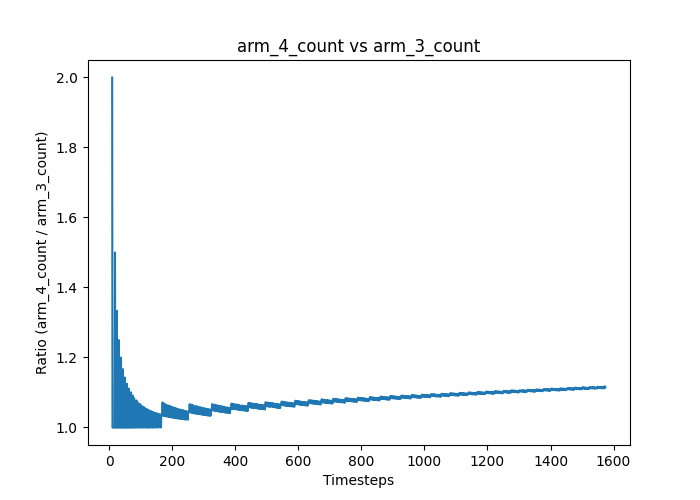

In [31]:
start = len(arm_names)
arm_a = 4
arm_b = 3
plt.figure(figsize=(7, 5))
plt.title(f"arm_{arm_a}_count vs arm_{arm_b}_count")
plt.xlabel("Timesteps")
plt.ylabel(f"Ratio (arm_{arm_a}_count / arm_{arm_b}_count)")
ratios = q_vals_df[f"arm_{arm_a}_count"] / q_vals_df[f"arm_{arm_b}_count"]
plt.plot(q_vals_df["timestep"], ratios)

0it [00:00, ?it/s]

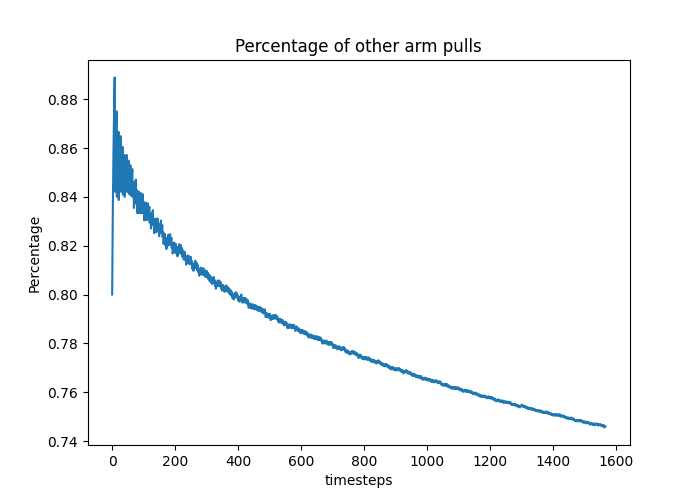

In [57]:
main_arm = 4
x = []
y = []
for i, row in tqdm(q_vals_df.iterrows()):
    main_arm_name = f"arm_{main_arm}"
    other_arms = list(set(arm_names) - set([main_arm_name]))
    other_arm_count_col_names = [name+"_count" for name in other_arms]
    all_arm_count_col_names = [name+"_count" for name in arm_names]
    total_other_arm_count = row[other_arm_count_col_names].values.sum()
    total_all_arm_count = row[all_arm_count_col_names].values.sum()
    other_arm_frac = total_other_arm_count / total_all_arm_count
    
    x.append(i)
    y.append(other_arm_frac)

plt.figure(figsize=(7, 5))
plt.title("Percentage of other arm pulls")
plt.ylabel("Percentage")
plt.xlabel("timesteps")
plt.plot(x, y)


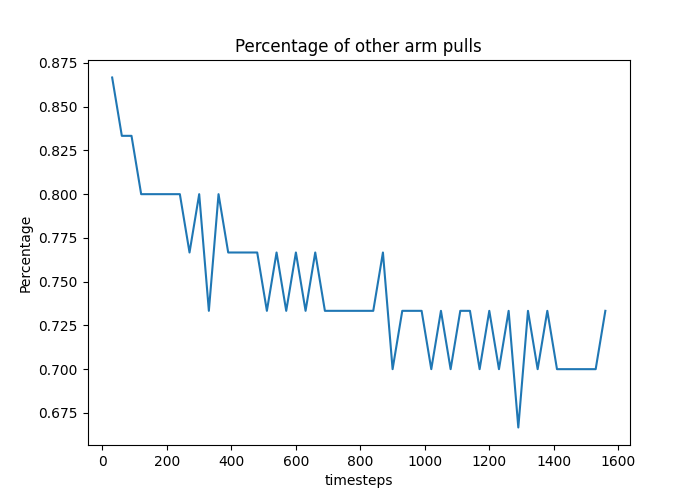

In [67]:
main_arm = 4
interval_size = 30
x = []
y = []
for i in range(interval_size, len(q_vals_df), interval_size):
    main_arm_name = f"arm_{main_arm}"
    other_arms = list(set(arm_names) - set([main_arm_name]))
    other_arm_count_col_names = [name+"_count" for name in other_arms]
    all_arm_count_col_names = [name+"_count" for name in arm_names]
    other_arm_counts = q_vals_df.loc[i, other_arm_count_col_names].values
    other_arm_count_tm1 = q_vals_df.loc[i-interval_size, other_arm_count_col_names].values
    other_arm_diff = (other_arm_counts - other_arm_count_tm1).sum()
    
    other_arm_frac = other_arm_diff / interval_size
    
    x.append(i)
    y.append(other_arm_frac)

plt.figure(figsize=(7, 5))
plt.title("Percentage of other arm pulls")
plt.ylabel("Percentage")
plt.xlabel("timesteps")
plt.plot(x, y)


In [65]:
len(q_vals_df)

1566

In [48]:
other_arms

['arm_3', 'arm_5', 'arm_7', 'arm_1', 'arm_8', 'arm_2', 'arm_6', 'arm_0']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


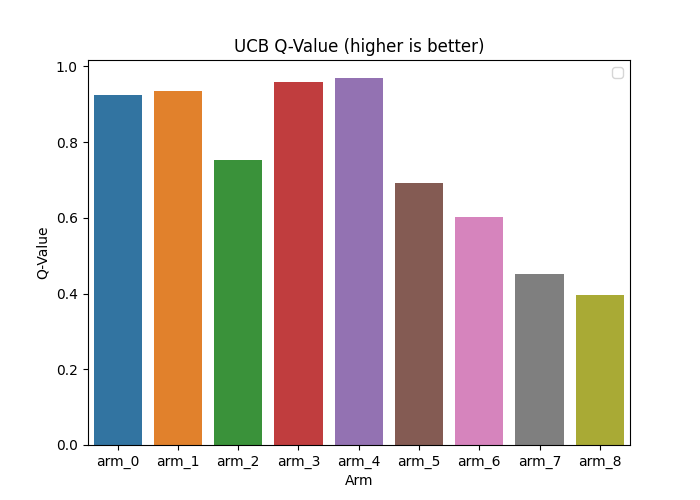

In [6]:
q_bar_plot_df = {"arm": [],
                 "score": []}
for arm in arm_names:
    q_bar_plot_df["arm"].append(arm)
    q_bar_plot_df["score"].append(1+q_vals_df[f"{arm}_value"].values[-1])

plt.figure(figsize=(7, 5))
plt.title("UCB Q-Value (higher is better)")
# for i, arm in enumerate(arm_names):
#     # sns.lineplot(x="timestep", y=f"{arm}_value", data=q_vals_df)
#     if i == 6:
#         alpha = 1
#     else:
#         alpha = 0.1
sns.barplot(x="arm", y="score", data=q_bar_plot_df)
plt.ylabel("Q-Value")
plt.xlabel("Arm")
plt.legend()

Text(0.5, 0, 'Arm')

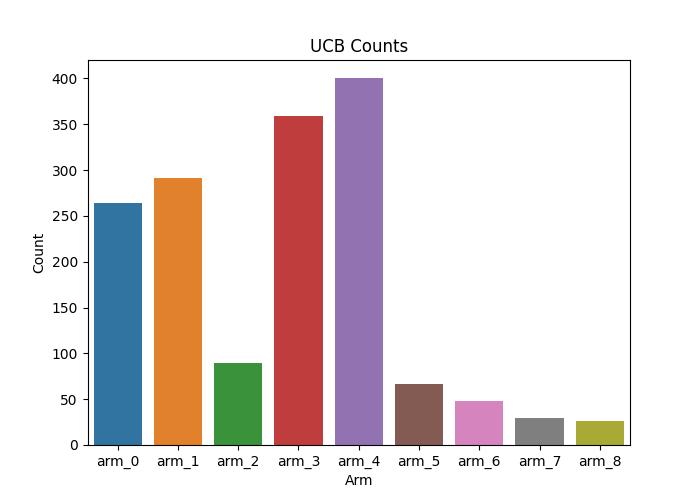

In [7]:
count_bar_plot_df = {"arm": [],
               "count": []}
for arm in arm_names:
    count_bar_plot_df["arm"].append(arm)
    count_bar_plot_df["count"].append(q_vals_df[f"{arm}_count"].values[-1])
# print(bar_plot_df)
plt.figure(figsize=(7, 5))
plt.title("UCB Counts")
sns.barplot(x="arm", y="count", data=count_bar_plot_df)
plt.ylabel("Count")
plt.xlabel("Arm")

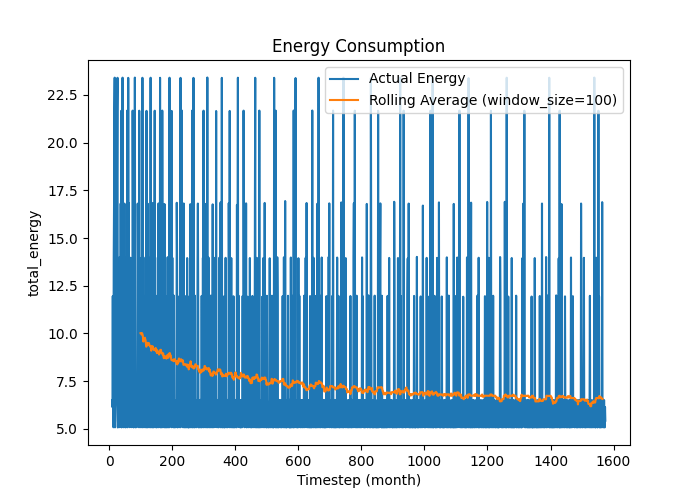

In [71]:

# running_average = q_vals_df["total_energy"].rolling(window=3).mean()
window_size = 100
alpha = 0.1
ema = q_vals_df["total_energy"].ewm(alpha=alpha, adjust=False).mean()
rolling_avg = q_vals_df["total_energy"].rolling(window=window_size).mean()

plt.figure(figsize=(7, 5))
plt.title("Energy Consumption")
sns.lineplot(x="timestep", y="total_energy", data=q_vals_df, label="Actual Energy")
plt.plot(rolling_avg, label=f"Rolling Average (window_size={window_size})")
# plt.plot(ema, label=f"EMA (alpha={alpha})")
plt.ylabel("total_energy")
plt.xlabel("Timestep (month)")
plt.legend()

In [51]:
timestep = q_val_dfs[all_zones[0]]["timestep"].values[-1]
zone_eval_dfs = {}

for zone in all_zones:
    # zone_eval_df = eval_df[eval_df["zone"] == zone]
    zone_eval_df = pd.DataFrame(columns=["datetime", "policy", "zone", "energy"])
    for name in policy_names:
        name = f"policy_library/{name}.pth"
        zone_eval_df = pd.concat([zone_eval_df, eval_df[eval_df["policy"] == name]])
        # print(zone_eval_df)
    zone_eval_df = zone_eval_df[zone_eval_df["zone"] == zone]
    zone_eval_df = zone_eval_df.sort_values(by=["energy"])
    zone_eval_dfs[zone] = zone_eval_df

NameError: name 'q_val_dfs' is not defined

In [7]:
for zone in all_zones:
    print(zone)
    ucb_row_idx = q_val_dfs[zone]["timestep"].values[-1]
    row = q_val_dfs[zone][q_val_dfs[zone]["timestep"] == ucb_row_idx]
    ucb_scores =[]
    for policy_name in zone_eval_dfs[zone]["policy"].values:
        col_name = policy_name[15:-4] + "_value"
        value = row[col_name].values[0]
        ucb_scores.append(value)
    zone_eval_dfs[zone]["ucb_scores"] = ucb_scores

Core_top
Core_mid
Perimeter_bot_ZN_4
Perimeter_mid_ZN_3
Perimeter_mid_ZN_2
Perimeter_mid_ZN_1
Perimeter_mid_ZN_4
Core_bottom
Perimeter_top_ZN_3
Perimeter_top_ZN_2
Perimeter_top_ZN_1
Perimeter_top_ZN_4
Perimeter_bot_ZN_3
Perimeter_bot_ZN_2
Perimeter_bot_ZN_1


In [8]:
ucb_corr = {}
for zone in all_zones:
    ucb_corr[zone] = spearmanr(zone_eval_dfs[zone]["energy"].values, zone_eval_dfs[zone]["ucb_scores"].values)
ucb_corr

{'Core_top': SpearmanrResult(correlation=-0.6428052325581395, pvalue=2.3465000771703512e-31),
 'Core_mid': SpearmanrResult(correlation=-0.5288859605465568, pvalue=6.339121805997292e-20),
 'Perimeter_bot_ZN_4': SpearmanrResult(correlation=-0.6079745328477061, pvalue=2.2892190602075086e-27),
 'Perimeter_mid_ZN_3': SpearmanrResult(correlation=-0.2955353305130757, pvalue=1.415172547703067e-06),
 'Perimeter_mid_ZN_2': SpearmanrResult(correlation=-0.5543828047235543, pvalue=4.1399556564935536e-22),
 'Perimeter_mid_ZN_1': SpearmanrResult(correlation=-0.3100221416613881, pvalue=3.950956406668295e-07),
 'Perimeter_mid_ZN_4': SpearmanrResult(correlation=-0.5156207583024159, pvalue=7.37588886420176e-19),
 'Core_bottom': SpearmanrResult(correlation=-0.6970127137815582, pvalue=1.0463918121800788e-38),
 'Perimeter_top_ZN_3': SpearmanrResult(correlation=-0.3762667883908585, pvalue=4.2268920597798157e-10),
 'Perimeter_top_ZN_2': SpearmanrResult(correlation=-0.4551560661931046, pvalue=1.511839162892136

In [34]:
with open("data/ucb_corr_19_07_2022.pkl", "wb+") as f:
    pickle.dump(ucb_corr, f)

In [19]:
ucb_raw_scores = {}
for zone in all_zones:
    for policy in zone_eval_dfs[zone]["policy"].unique():
        if "../"+policy not in ucb_raw_scores:
            ucb_raw_scores["../"+policy] = {}
        ucb_score = zone_eval_dfs[zone][zone_eval_dfs[zone]["policy"] == policy]["ucb_scores"].values[0]
        ucb_raw_scores["../"+policy][zone] = ucb_score
        # if zone not in ucb_raw_scores[policy]:

with open("data/ucb_raw_scores_19_07_2022.pkl", "wb+") as f:
    pickle.dump(ucb_raw_scores, f)

In [20]:
ucb_raw_scores

{'../policy_library/105_1_1e1.pth': {'Core_top': -0.1353667143509694,
  'Core_mid': -0.1541819169895615,
  'Perimeter_bot_ZN_4': -0.1127720964937491,
  'Perimeter_mid_ZN_3': -0.1395068537532783,
  'Perimeter_mid_ZN_2': -0.1202171971035569,
  'Perimeter_mid_ZN_1': -0.1413759793412537,
  'Perimeter_mid_ZN_4': -0.1100615039833636,
  'Core_bottom': -0.1550775898041095,
  'Perimeter_top_ZN_3': -0.1464032886219858,
  'Perimeter_top_ZN_2': -0.1420548926226018,
  'Perimeter_top_ZN_1': -0.1362829544392945,
  'Perimeter_top_ZN_4': -0.1463159687658813,
  'Perimeter_bot_ZN_3': -0.1781015886022698,
  'Perimeter_bot_ZN_2': -0.1433858269688645,
  'Perimeter_bot_ZN_1': -0.1589674836294666},
 '../policy_library/104_4_1e0.pth': {'Core_top': -0.142212351227232,
  'Core_mid': -0.1763066680521813,
  'Perimeter_bot_ZN_4': -0.1320038084207044,
  'Perimeter_mid_ZN_3': -0.1232137479376921,
  'Perimeter_mid_ZN_2': -0.1149473445570865,
  'Perimeter_mid_ZN_1': -0.1263495736061141,
  'Perimeter_mid_ZN_4': -0.13896